## Data Preprocessing

In [ ]:
import pandas as pd
import numpy as np
import datetime as dt
from datetime import timedelta
import matplotlib.pyplot as plt
from scipy.stats import f

import plotly.graph_objects as go
from sklearn.metrics import mean_squared_error
from scipy.stats import skew, kurtosis
import tensorflow_probability as tfp 
from tensorflow_probability import distributions as tfd
import plotly.io as pio
import seaborn as sns

## Calendar data

In [2]:
df_holiday= pd.read_csv("holidays_all.csv")
#df_holiday

In [ ]:
df_holiday = df_holiday[df_holiday['CountryCode'] == 'ES']

# 3. Convert Date to datetime type
df_holiday['Date'] = pd.to_datetime(df_holiday['Date'])
df_holiday = df_holiday[df_holiday['Date'] >= '2015-01-01']
df_holiday = df_holiday[df_holiday['Date'] <= '2026-12-31']
df_holiday = df_holiday.drop(columns=['LocalName', 'LaunchYear'])
df_holiday


In [4]:
# # Check holiday name 
# df_global = df_holiday[df_holiday['Global'] == False]
# unique_names = df_global['Name'].unique()

# for name in unique_names:
#     print(name)

#df_holiday.to_csv("holiday_preprocessing.csv")

In [5]:
## Read data after processing

df_holiday= pd.read_csv("holiday_preprocessing.csv").drop(columns=['Unnamed: 0'])
df_holiday

,Date,Name,CountryCode,Fixed,Global,Type,Counties
0,01/01/2015,New Year's Day,ES,True,True,Public,NaN
1,06/01/2015,Epiphany,ES,True,True,Public,NaN
2,28/02/2015,Day of Andalucía,ES,True,False,Public,ES-AN
3,01/03/2015,Day of the Balearic Islands,ES,True,False,Public,ES-IB
4,19/03/2015,St. Joseph's Day,ES,True,False,Public,"ES-CM,ES-MD,ES-PV,ES-VC"
...,...,...,...,...,...,...,...
387,01/11/2026,All Saints Day,ES,True,True,Public,NaN
388,06/12/2026,Constitution Day,ES,True,True,Public,NaN
389,08/12/2026,Immaculate Conception,ES,True,True,Public,NaN
390,25/12/2026,Christmas Day,ES,True,True,Public,NaN


In [6]:
# # Check holiday name 
# unique_names = df_holiday['Name'].unique()

# for name in unique_names:
#     print(name)

# df_filtered= df_holiday[df_holiday['Name'] == "Assumption"]

#### Generate to DateTime

In [7]:
def generate_datetimes(start_datetime, end_datetime, delta):
    delta = delta
    current_datetime = start_datetime
    datetimes = []

    while current_datetime <= end_datetime:
        datetimes.append(current_datetime)
        current_datetime += delta

    return pd.Series(datetimes)
def aggregate_dummies(df):
    return df.max(axis=1)

#datetimes = generate_datetimes(dt.datetime(2015,1,1,0),dt.datetime.now(),dt.timedelta(hours=1))
datetimes = generate_datetimes(dt.datetime(2015,1,1,0),dt.datetime(2026,12,31,0),dt.timedelta(hours=1))
    
df = pd.DataFrame(datetimes,columns=["Date"])
df["Date_nominal"] = df["Date"].dt.strftime("%Y-%m-%d")
df

,Date,Date_nominal
0,2015-01-01 00:00:00,2015-01-01
1,2015-01-01 01:00:00,2015-01-01
2,2015-01-01 02:00:00,2015-01-01
3,2015-01-01 03:00:00,2015-01-01
4,2015-01-01 04:00:00,2015-01-01
...,...,...
105164,2026-12-30 20:00:00,2026-12-30
105165,2026-12-30 21:00:00,2026-12-30
105166,2026-12-30 22:00:00,2026-12-30
105167,2026-12-30 23:00:00,2026-12-30


In [8]:
df['Date_nominal'] = pd.to_datetime(df['Date_nominal'])
#df['Date_nominal'].dtypes
df_holiday = df_holiday.rename(columns={"Date":"Date_nominal"})
df_holiday['Date_nominal'] = pd.to_datetime(df_holiday['Date_nominal'], format='%d/%m/%Y')

In [9]:
df_holidays = pd.merge(df,df_holiday, on=["Date_nominal"], how = "left")
df_holidays.rename(columns={"Date": "DateTime"}, inplace=True)
df_holidays = df_holidays.drop(columns=['Date_nominal'])
# df_holidays.set_index('DateTime', inplace=True)
# # Localize the index to 'Europe/Madrid' directly (assuming the dates are already in local time)
# df_holidays.index = df_holidays.index.tz_localize('Europe/Madrid', nonexistent='shift_forward', ambiguous='NaT')
# df_holidays


In [10]:
# # Check holiday name 
# df_global = df_holiday[df_holiday['Global'] == False]
# unique_names = df_global['Name'].unique()

# for name in unique_names:
#     print(name)

#df_holiday.to_csv("holiday_preprocessing_DateTime.csv", index=False)

## Allocation data 

In [35]:
df_load = pd.read_csv("ES_Load.csv")
df_load['DateTime'] = pd.to_datetime(df_load['DateTime'])
df_load['DateTime'] = df_load['DateTime'].dt.tz_localize(None)

df_load

,DateTime,Load_DA,Load_ACT
0,2017-12-31 23:00:00,23324.00,27326.0
1,2018-01-01 00:00:00,22688.00,22009.0
2,2018-01-01 01:00:00,21521.00,20589.0
3,2018-01-01 02:00:00,20294.00,19547.0
4,2018-01-01 03:00:00,19489.00,18871.0
...,...,...,...
56250,2024-06-01 17:00:00,24475.00,24673.0
56251,2024-06-01 18:00:00,25258.25,25588.0
56252,2024-06-01 19:00:00,26165.25,26240.0
56253,2024-06-01 20:00:00,25591.50,25973.0


In [36]:
df_load.set_index('DateTime', inplace=True)

# Display the DataFrame to ensure the correct index and format
print("Original DataFrame with DateTime as the index:")
print(df_load)

# Method 1: Filter data from '2018-01-01' onward
df_load = df_load.loc['2018-01-01':]
df_load.reset_index(inplace=True)

Original DataFrame with DateTime as the index:
                      Load_DA  Load_ACT
DateTime                               
2017-12-31 23:00:00  23324.00   27326.0
2018-01-01 00:00:00  22688.00   22009.0
2018-01-01 01:00:00  21521.00   20589.0
2018-01-01 02:00:00  20294.00   19547.0
2018-01-01 03:00:00  19489.00   18871.0
...                       ...       ...
2024-06-01 17:00:00  24475.00   24673.0
2024-06-01 18:00:00  25258.25   25588.0
2024-06-01 19:00:00  26165.25   26240.0
2024-06-01 20:00:00  25591.50   25973.0
2024-06-01 21:00:00  23931.50   24258.0

[56255 rows x 2 columns]


In [37]:
# Check for missing values in each column
missing_values_sum = df_load.isna().sum()

# Display the number of missing values in each column
print("Number of missing values in each column:")
print(missing_values_sum)

Number of missing values in each column:
DateTime    0
Load_DA     0
Load_ACT    0
dtype: int64


In [38]:

df_hol_allo = pd.merge(df_load,df_holidays, on=["DateTime"], how = "left")
df_hol_allo= df_hol_allo.drop(columns=['Type','Load_ACT', 'CountryCode'])
df_hol_allo

,DateTime,Load_DA,Name,Fixed,Global,Counties
0,2018-01-01 00:00:00,22688.00,New Year's Day,True,True,NaN
1,2018-01-01 01:00:00,21521.00,New Year's Day,True,True,NaN
2,2018-01-01 02:00:00,20294.00,New Year's Day,True,True,NaN
3,2018-01-01 03:00:00,19489.00,New Year's Day,True,True,NaN
4,2018-01-01 04:00:00,19179.00,New Year's Day,True,True,NaN
...,...,...,...,...,...,...
56753,2024-06-01 17:00:00,24475.00,NaN,NaN,NaN,NaN
56754,2024-06-01 18:00:00,25258.25,NaN,NaN,NaN,NaN
56755,2024-06-01 19:00:00,26165.25,NaN,NaN,NaN,NaN
56756,2024-06-01 20:00:00,25591.50,NaN,NaN,NaN,NaN


In [39]:
df_hol_allo['Load_DA'] = df_hol_allo['Load_DA'] / 1000 

# start from here

In [40]:
import plotly.express as px

# Create a scatter plot with Plotly for Load_DA on New Year's Day over time
fig = px.line(df_hol_allo, x='DateTime', y='Load_DA', title="Load_DA Over Time")

# Update the layout for better visualization
fig.update_layout(
    xaxis_title='DateTime',
    yaxis_title='Load_DA (GW)',
    title="Load_DA Over Time",
    plot_bgcolor='white',
    paper_bgcolor='white'
)

# Show the plot
fig.show()

In [41]:
# Calculate the mean, standard deviation, minimum, and maximum for the specified column
mean_value = df_hol_allo['Load_DA'].mean()
median_value = df_hol_allo['Load_DA'].median()
std_dev_value = df_hol_allo['Load_DA'].std()
min_value = df_hol_allo['Load_DA'].min()
max_value = df_hol_allo['Load_DA'].max()
skewness_value = skew(df_hol_allo['Load_DA'])
kurtosis_value = kurtosis(df_hol_allo['Load_DA'])


summary_data = pd.DataFrame({
    'Mean': [mean_value],
    'Median': [median_value],
    'Standard Deviation': [std_dev_value],
    'Minimum': [min_value],
    'Maximum': [max_value],
    'Skewness': [skewness_value],
    'Kurtosis': [kurtosis_value]
})

print(summary_data)

       Mean   Median  Standard Deviation  Minimum  Maximum  Skewness  Kurtosis
0  27.50325  27.3955            4.521854    15.33   41.786  0.136875 -0.740001


## Sort public and regional. Fixed and flexible holiday

### Fixed and flexible public holiday

### Fixed and flexible reginal holiday

In [42]:
fixed_reghols = df_hol_allo[(df_hol_allo['Global'] == False) & (df_hol_allo['Fixed'] == True)]
flex_reghols = df_hol_allo[(df_hol_allo['Global'] == False) & (df_hol_allo['Fixed'] == False)]

## Calculate flexible holiday

In [ ]:
flex_pubhols = df_hol_allo[(df_hol_allo['Global'] == True) & (df_hol_allo['Fixed'] == False)]
df_hol_allo['is_flex_holiday'] = 0

# Update 'is_holiday' for flexible public holidays and surrounding time
for index, row in flex_pubhols.iterrows():
    holiday_date = row['DateTime'].normalize()  # Get the date part only
    start_time = holiday_date - pd.Timedelta(hours=6)  # 6 hours before
    end_time = holiday_date + pd.Timedelta(days=1, hours=6)  # 6 hours after the holiday day ends
    
    df_hol_allo.loc[(df_hol_allo['DateTime'] >= start_time) & (df_hol_allo['DateTime'] <= end_time), 'is_flex_holiday'] = 1

df_hol_allo


### Ocal option

holiday =1
non holiday=0

In [180]:
# flex_pubhols = df_hol_allo[(df_hol_allo['Global'] == True) & (df_hol_allo['Fixed'] == False)]
# df_hol_allo['is_flex_holiday'] = 0

# # Update 'is_flex_holiday' for flexible public holidays
# for index, row in flex_pubhols.iterrows():
#     holiday_date = row['DateTime'].normalize()  # Get the date part only
#     df_hol_allo.loc[df_hol_allo['DateTime'].dt.normalize() == holiday_date, 'is_flex_holiday'] = 1

# df_hol_allo

In [ ]:
is_holiday = df_hol_allo[(df_hol_allo['is_flex_holiday'] == 1)] # also take regional Maundy Thursday because its 6 hours before 03-04
is_holiday

## calculate fixed holiday

sunday is 0 and low level load

tue, wed, thur is 1 and high level load

chosing Ct by max function

In [46]:

fixed_pubhols = df_hol_allo[(df_hol_allo['Global'] == True) & (df_hol_allo['Fixed'] == True)]
df_hol_allo['is_fixed_holiday'] = 0

# Add hour, day, and week columns
df_hol_allo['Hour'] = df_hol_allo['DateTime'].dt.hour
df_hol_allo['Day'] = df_hol_allo['DateTime'].dt.dayofweek
df_hol_allo['Week'] = df_hol_allo['DateTime'].dt.isocalendar().week

# Function to calculate weekly mean load values
def calculate_weekly_mean_loads(week):
    weekly_data = df_hol_allo[df_hol_allo['Week'] == week]
    
    high_level_load_days = weekly_data[weekly_data['Day'].isin([1, 2, 3])]  # Tue, Wed, Thu
    low_level_load_days = weekly_data[weekly_data['Day'] == 6]  # Sunday
    
    high_level_load = high_level_load_days.groupby('Hour')['Load_DA'].mean()
    low_level_load = low_level_load_days.groupby('Hour')['Load_DA'].mean()
    actual_load_target = weekly_data.groupby('Hour')['Load_DA'].mean()
    
    return high_level_load, low_level_load, actual_load_target

# Store the weekly mean load values in a dictionary
weekly_mean_loads = {}
for week in df_hol_allo['Week'].unique():
    weekly_mean_loads[week] = calculate_weekly_mean_loads(week)

# Define the coefficient C(t)
def calculate_coefficient(hour, day, week):
    if week not in weekly_mean_loads:
        return np.nan

    high_level_load, low_level_load, actual_load_target = weekly_mean_loads[week]
    actual_load_val = actual_load_target.get(hour, np.nan)

    if day == 6:  # Sunday
        return 0
    elif day in [1, 2, 3]:  # Tuesday, Wednesday, Thursday
        return 1
    else:  # Monday, Friday, Saturday
        high_load = high_level_load.get(hour, np.nan)
        low_load = low_level_load.get(hour, np.nan)
        if pd.isna(high_load) or pd.isna(low_load) or pd.isna(actual_load_val):
            return np.nan
        C_t = max(1 - ((high_load - actual_load_val) / (high_load - low_load)), 0)
        return min(C_t, 1)

# Apply the coefficient to fixed holidays and surrounding hours
for index, row in fixed_pubhols.iterrows():
    start_time = row['DateTime'] - pd.Timedelta(hours=6)
    end_time = row['DateTime'] + pd.Timedelta(hours=6)
    
    for time in pd.date_range(start_time, end_time, freq='H'):
        hour = time.hour
        day = time.weekday()
        week = time.isocalendar()[1]
        coeff = calculate_coefficient(hour, day, week)
        if not pd.isna(coeff):
            df_hol_allo.loc[df_hol_allo['DateTime'] == time, 'is_fixed_holiday'] = coeff

# The Actual_Load_Target column is no longer needed
df_hol_allo = df_hol_allo.drop(columns=['Actual_Load_Target'], errors='ignore')


In [ ]:
is_holiday = df_hol_allo[df_hol_allo['is_fixed_holiday'] != 0] # 3 is thursday search for not equal to 0
is_holiday

In [ ]:
df_hol_allo['is_regional_holiday'] = 0
# Define the short_code and population percentages
short_code = ["ES-AN", "ES-CT", "ES-MD", "ES-VC", "ES-GA", "ES-CL", "ES-PV", "ES-CM", "ES-CN", "ES-MC", "ES-AR", "ES-IB", 
              "ES-EX", "ES-AS", "ES-NC", "ES-CB", "ES-RI", "ES-CE", "ES-ML"]
population_percentage = [17.88, 16.02, 13.75, 10.85, 5.88, 5.39, 4.64, 4.49, 4.48, 3.12, 2.86, 2.37, 2.34, 2.28, 1.36, 1.26, 
                         0.68, 0.18, 0.17]

# Create a dictionary for quick lookup
population_dict = dict(zip(short_code, population_percentage))

# Define a threshold for significant population percentage
threshold = 10.0  # Example threshold, adjust as needed

## if pop smaller than 15 then 0
# if greater then 1

### take the weight

# Identify regional holidays
regional_holidays = df_hol_allo[(df_hol_allo['Global'] == False)]

# Update 'is_holiday' for regional holidays based on population percentage
for index, row in regional_holidays.iterrows():
    counties = row['Counties'].split(',')
    total_population_weight = sum(population_dict.get(county.strip(), 0) for county in counties)
    print(f"Counties: {counties}, Total Population Weight: {total_population_weight}%")  # Print the total population weight
    if total_population_weight >= threshold:
        df_hol_allo.loc[index, 'is_regional_holiday'] = 1


# Display the resulting DataFrame
df_hol_allo

In [ ]:
is_holiday = df_hol_allo[(df_hol_allo['is_regional_holiday'] == 1)]
is_holiday

### Final holiday data

In [50]:
#df_hol_allo = pd.read_csv("holiday_regional_global.csv")
df_hol_allo= df_hol_allo.drop(columns=['Fixed', 'Global','Counties', 'Hour', 'Day', 'Week'])

In [ ]:
df_hol_allo

### Christmas and new year holiday

In [53]:
def is_christmas_holiday(date: pd.Timestamp):
    if date.month == 12 and date.day >= 24 or date.month == 1 and date.day <= 6:
        return 1
    else:
        return 0
df_hol_allo['is_xmas'] = df_hol_allo['DateTime'].apply(is_christmas_holiday)

In [ ]:
is_holiday = df_hol_allo[(df_hol_allo['is_xmas'] == 1)]
is_holiday

### Sum all holiday

In [55]:
df_hol_allo['is_holiday'] = (df_hol_allo['is_xmas'] +
                             df_hol_allo['is_regional_holiday'] +
                             df_hol_allo['is_fixed_holiday'] +
                             df_hol_allo['is_flex_holiday'])

In [ ]:
df_hol_allo

In [192]:
#df_hol_allo.to_csv("total_holiday_with66.csv", index=False)

option 6+24+6 has 7474 days of holiday
not 66 has 7544 days of holiday

In [ ]:

is_holiday = df_hol_allo[(df_hol_allo['is_holiday'] > 0)]
is_holiday

In [3]:
df_ho = pd.read_csv("total_holiday_with66.csv")

In [ ]:
flex_reghols = df_hol_allo[(df_hol_allo['Global'] == False) & (df_hol_allo['Fixed'] == False)]

In [ ]:
is_holiday = df_ho[(df_ho['is_holiday'] > 0)]
is_holiday

In [5]:
unique_names = is_holiday['Name'].unique()
unique_names

array(["New Year's Day", nan, 'Epiphany', 'Day of Andalucía',
       "St. Joseph's Day", 'Maundy Thursday', 'Good Friday',
       'Easter Monday', 'Labour Day', 'Day of Madrid', "St. John's Day",
       'Assumption', 'National Day of Catalonia',
       'Day of the Valencian Community', 'Fiesta Nacional de España',
       'Immaculate Conception', 'Christmas Day', "St. Stephen's Day",
       'All Saints Day', 'Constitution Day', 'Santiago Apóstol',
       'Whit Monday'], dtype=object)

## Make a coppy for modelling

In [58]:
df_hol_allo_copy = df_hol_allo.copy()

## Weather data

In [59]:
df_weather_act = pd.read_csv("weather_actuals.csv")
# Function to ensure consistent datetime parsing
def ensure_datetime_format(date_str):
    try:
        return pd.to_datetime(date_str, dayfirst=True)
    except ValueError:
        return pd.to_datetime(date_str + ' 00:00:00', dayfirst=True)

# Apply the function to the DateTime column
df_weather_act['DateTime'] = df_weather_act['DateTime'].apply(ensure_datetime_format)



In [ ]:
# Format DateTime to the desired string format
df_weather_act['DateTime'] = df_weather_act['DateTime'].dt.strftime('%d/%m/%Y %H:%M:%S')
df_weather_act

### Make a coppy for modeling

In [198]:
# df_weather_act = pd.read_csv("weather_actuals.csv")
# df_weather_act['DateTime'] = pd.to_datetime(df_weather_act['DateTime'].str.replace('Z', ''), format='%Y-%m-%dT%H:%M:%S')

# # Format DateTime to the desired string format
# df_weather_act['DateTime'] = df_weather_act['DateTime'].dt.strftime('%Y-%m-%d %H:%M:%S')
# df_weather_act


## Feature calculation

In [69]:
def moving_average_filter(series_in, filter_size_left, filter_size_right):

    # Calc moving average
    window_size = filter_size_left + filter_size_right + 1
    series_out = series_in.rolling(window=window_size).mean()

    # Shift series
    series_out = series_out.shift(periods=-filter_size_right)

    return series_out

In [70]:

# Create dictionary with {prefix_name of the new feature: name of the underlying attribute/column}
feature_name_mapping = {'temp': 'temp_actual'}

for feature_prefix, attribute_col in feature_name_mapping.items():
                
# Calculate moving averages
    for filter_size_left in [24, 48, 72]:
        filter_size_right = 0
        df_weather_act[f'{feature_prefix}_{filter_size_left}hour_MA'] = moving_average_filter(df_weather_act[attribute_col], filter_size_left=filter_size_left, filter_size_right=filter_size_right)


C:\Users\L27898\AppData\Local\Temp\ipykernel_242828\3815685050.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [71]:
# Check for missing values in each column
missing_values_sum = df_weather_act.isna().sum()

# Display the number of missing values in each column
print("Number of missing values in each column:")
print(missing_values_sum)

Number of missing values in each column:
DateTime           0
temp_actual        0
wspd_actual        0
temp_24hour_MA    24
temp_48hour_MA    48
temp_72hour_MA    72
dtype: int64


In [72]:
df_weather_act = df_weather_act.dropna()

df_weather_act

,DateTime,temp_actual,wspd_actual,temp_24hour_MA,temp_48hour_MA,temp_72hour_MA
144,30/12/2014 00:00:00,6.214286,18.014286,7.840643,9.379993,9.867613
145,30/12/2014 01:00:00,5.814286,14.885714,7.779714,9.255211,9.842564
146,30/12/2014 02:00:00,5.057143,14.900000,7.685429,9.115270,9.813014
147,30/12/2014 03:00:00,4.514286,13.500000,7.574571,8.971538,9.777397
148,30/12/2014 04:00:00,3.237500,12.712500,7.410929,8.798251,9.731140
...,...,...,...,...,...,...
82985,11/06/2024 18:00:00,27.300000,11.100000,23.609222,23.226361,23.103447
82986,11/06/2024 19:00:00,25.800000,9.300000,23.597222,23.246361,23.118105
82987,11/06/2024 20:00:00,24.300000,9.300000,23.571000,23.258810,23.126324
82988,11/06/2024 21:00:00,22.800000,7.400000,23.533222,23.258810,23.125502


## Join all data

In [73]:
df_weather_act['DateTime'] = pd.to_datetime(df_weather_act['DateTime'], dayfirst=True)
df_weather_act

C:\Users\L27898\AppData\Local\Temp\ipykernel_242828\2659090217.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,DateTime,temp_actual,wspd_actual,temp_24hour_MA,temp_48hour_MA,temp_72hour_MA
144,2014-12-30 00:00:00,6.214286,18.014286,7.840643,9.379993,9.867613
145,2014-12-30 01:00:00,5.814286,14.885714,7.779714,9.255211,9.842564
146,2014-12-30 02:00:00,5.057143,14.900000,7.685429,9.115270,9.813014
147,2014-12-30 03:00:00,4.514286,13.500000,7.574571,8.971538,9.777397
148,2014-12-30 04:00:00,3.237500,12.712500,7.410929,8.798251,9.731140
...,...,...,...,...,...,...
82985,2024-06-11 18:00:00,27.300000,11.100000,23.609222,23.226361,23.103447
82986,2024-06-11 19:00:00,25.800000,9.300000,23.597222,23.246361,23.118105
82987,2024-06-11 20:00:00,24.300000,9.300000,23.571000,23.258810,23.126324
82988,2024-06-11 21:00:00,22.800000,7.400000,23.533222,23.258810,23.125502


In [74]:
df_join = df_hol_allo_copy.merge(df_weather_act, on='DateTime', how='left') 

In [76]:
# Check for missing values in each column
missing_values_sum = df_join.isna().sum()

# Display the number of missing values in each column
print("Number of missing values in each column:")
print(missing_values_sum)

Number of missing values in each column:
DateTime                   0
Load_DA                    0
Name                   51622
is_flex_holiday            0
is_fixed_holiday           0
is_regional_holiday        0
is_xmas                    0
is_holiday                 0
temp_actual                0
wspd_actual                0
temp_24hour_MA             0
temp_48hour_MA             0
temp_72hour_MA             0
dtype: int64


In [78]:
df_join.to_csv("Final_Load.csv", index= False)

In [79]:
df_join.columns

Index(['DateTime', 'Load_DA', 'Name', 'is_flex_holiday', 'is_fixed_holiday',
       'is_regional_holiday', 'is_xmas', 'is_holiday', 'temp_actual',
       'wspd_actual', 'temp_24hour_MA', 'temp_48hour_MA', 'temp_72hour_MA'],
      dtype='object')

In [ ]:
data= pd.read_csv("Final_Load.csv")
data.set_index('DateTime', inplace=True)
duplicates = data[data.index.duplicated(keep=False)]
data = data[~data.index.duplicated(keep='first')]
data.reset_index(inplace=True)

In [109]:
# Check for missing values in each column
missing_values_sum = data.isna().sum()

# Display the number of missing values in each column
print("Number of missing values in each column:")
print(missing_values_sum)

Number of missing values in each column:
DateTime                   0
Load_DA                    0
Name                   51622
is_flex_holiday            0
is_fixed_holiday           0
is_regional_holiday        0
is_xmas                    0
is_holiday                 0
temp_actual                0
wspd_actual                0
temp_24hour_MA             0
temp_48hour_MA             0
temp_72hour_MA             0
dtype: int64


In [110]:
# Calculate the mean, standard deviation, minimum, and maximum for the specified column
mean_value = data['Load_DA'].mean()
median_value = data['Load_DA'].median()
std_dev_value = data['Load_DA'].std()
min_value = data['Load_DA'].min()
max_value = data['Load_DA'].max()
skewness_value = skew(data['Load_DA'])
kurtosis_value = kurtosis(data['Load_DA'])


summary_data = pd.DataFrame({
    'Mean': [mean_value],
    'Median': [median_value],
    'Standard Deviation': [std_dev_value],
    'Minimum': [min_value],
    'Maximum': [max_value],
    'Skewness': [skewness_value],
    'Kurtosis': [kurtosis_value]
})

print(summary_data)

       Mean    Median  Standard Deviation  Minimum  Maximum  Skewness  \
0  27.51459  27.40875            4.527494    15.33   41.786  0.136174   

   Kurtosis  
0  -0.74491  


In [111]:
data.set_index('DateTime', inplace=True)

In [100]:

start_date = '2019-02-01'
end_date = '2020-01-15'
filtered_data = data.loc[start_date:end_date]

# Create the plot
trace_load = go.Scatter(x=filtered_data.index, y=filtered_data["Load_DA"], mode='lines', name='Load_DA')

fig = go.Figure(data=[trace_load])
fig.update_layout(
    title='Load_DA Over Time',
    xaxis=dict(title='Time'),
    yaxis=dict(title='Load_DA (MW)'),
    template='plotly_white'
)

# Add the gray shaded area for the Christmas holiday
fig.add_shape(
    type="rect",
    x0='2019-12-24',
    x1='2020-01-07',
    y0=filtered_data["Load_DA"].min(),
    y1=filtered_data["Load_DA"].max(),
    fillcolor="gray",
    opacity=0.5,
    layer="below",
    line_width=0
)

# Add the gray shaded area for the Christmas holiday
fig.add_shape(
    type="rect",
    x0='2019-04-14',
    x1='2019-04-15',
    y0=filtered_data["Load_DA"].min(),
    y1=filtered_data["Load_DA"].max(),
    fillcolor="pink",
    opacity=0.5,
    layer="below",
    line_width=0
)

# Add the gray shaded area for the Christmas holiday
fig.add_shape(
    type="rect",
    x0='2019-04-17',
    x1='2019-04-18',
    y0=filtered_data["Load_DA"].min(),
    y1=filtered_data["Load_DA"].max(),
    fillcolor="purple",
    opacity=0.5,
    layer="below",
    line_width=0
)

# Add the gray shaded area for the Christmas holiday
fig.add_shape(
    type="rect",
    x0='2019-11-11',
    x1='2019-11-12',
    y0=filtered_data["Load_DA"].min(),
    y1=filtered_data["Load_DA"].max(),
    fillcolor="purple",
    opacity=0.5,
    layer="below",
    line_width=0
)

In [12]:
data= pd.read_csv("Final_dataset.csv")

In [13]:
data['DateTime'] = pd.to_datetime(data['DateTime'])
data.set_index('DateTime', inplace=True)

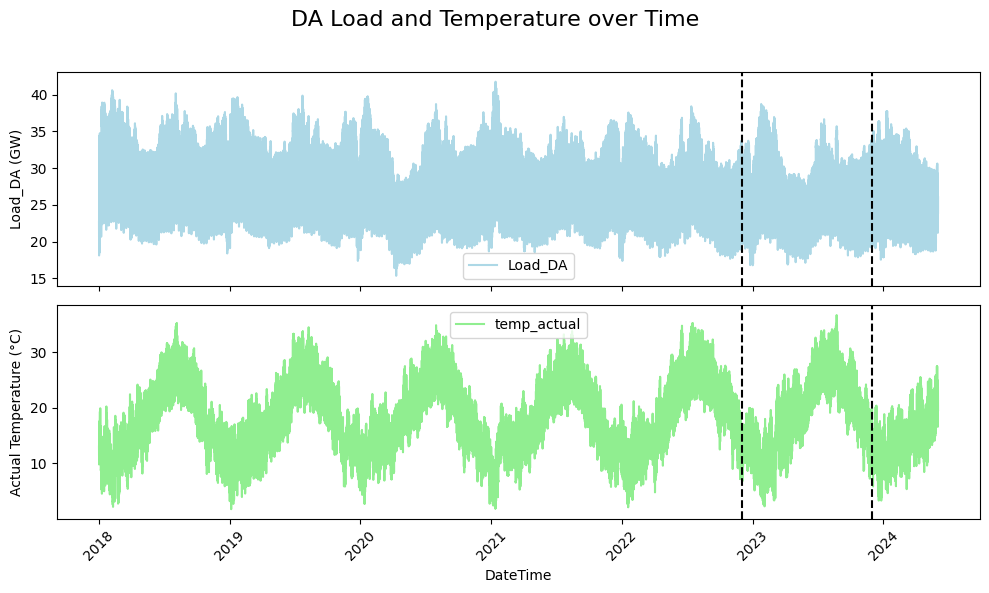

In [15]:


# Create figure and axes
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

# Plot Load_DA
ax1.plot(data.index, data['Load_DA'], label='Load_DA', color='lightblue')
ax1.set_ylabel('Load_DA (GW)')
ax1.legend()

# Plot Actual Temperature
ax2.plot(data.index, data['temp_actual'], label='temp_actual', color='lightgreen')
ax2.set_ylabel('Actual Temperature (°C)')
ax2.legend()

# Set the main title
fig.suptitle('DA Load and Temperature over Time', fontsize=16)

# Set x-axis label
ax2.set_xlabel('DateTime')

# Rotate x-axis labels
plt.xticks(rotation=45)

# Add vertical lines to separate training, validation, QRA, and testing sets
ax1.axvline(pd.Timestamp('2022-12-01 08:00:00'), color='black', linestyle='--')
ax2.axvline(pd.Timestamp('2022-12-01 08:00:00'), color='black', linestyle='--')
ax1.axvline(pd.Timestamp('2023-12-01 08:00:00'), color='black', linestyle='--')
ax2.axvline(pd.Timestamp('2023-12-01 08:00:00'), color='black', linestyle='--')

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Show plot
plt.show()
